In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tensorflow import keras
import os
import sys
import scipy as sp
from scipy.special import rel_entr
from textwrap import wrap

## Define functions

In [2]:
def js_div(p, q, bins=100):
    p_hist, _ = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bins, density=True)
    m = 0.5*p_hist + 0.5*q_hist
    kl_1 = sum(rel_entr(p_hist, m))
    kl_2 = sum(rel_entr(q_hist, m))
    return 0.5*(kl_1 + kl_2)

## Set Paths

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''
print(os.environ['CUDA_VISIBLE_DEVICES'])

In [137]:
sys.path.append('../models/cWGAN/Run_2021-01-23_0/')
import cWGAN

In [138]:
save_dir = '../models/cWGAN/Run_2021-01-23_0/'
assert(os.path.isdir(save_dir))

## Plot Loss Curve

In [139]:
gen_losses = []
with open(save_dir+'generator_losses.txt', 'r') as f:
    for _ in range(100000):
        line = f.readline()
        begin = int(line.find(')'))
        start = int(line.find('(', begin))
        end = int(line.find(',', begin+2))
        if start > 0:
            gen_losses.append(float(line[start+1:end]))

In [140]:
critic_losses = []
with open(save_dir+'critic_losses.txt', 'r') as f:
    for _ in range(500000):
        line = f.readline()
        start = int(line.find('('))
        end = int(line.find(','))
        if start > 0:
            critic_losses.append(float(line[start+1:end]))

In [141]:
filtered_gen_losses = sp.ndimage.median_filter(gen_losses, size=20)
filtered_critic_losses = sp.ndimage.median_filter(critic_losses, size=20)

In [142]:
print(len(filtered_gen_losses))
print(len(filtered_critic_losses))
iterations = np.arange(len(filtered_gen_losses))
iterations*=5

51530
257650


Text(0.5, 1.0, 'Wasserstein Distance')

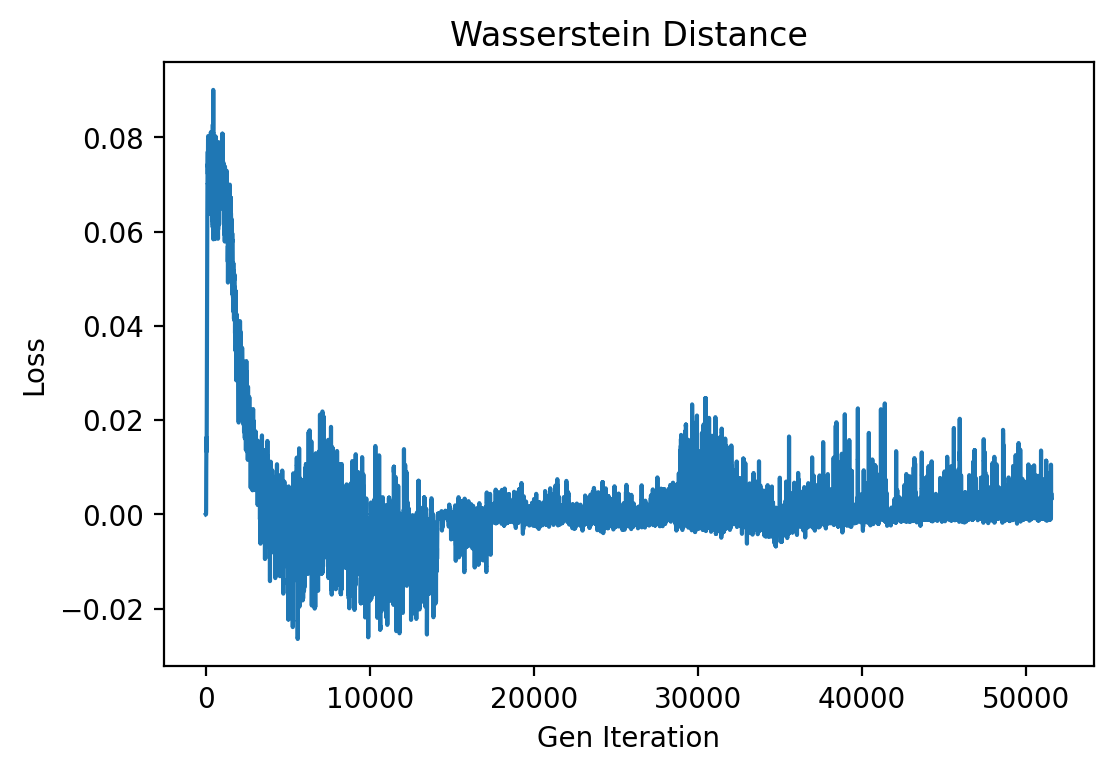

In [143]:
fig = plt.figure(dpi=200)
ax = fig.add_subplot(111)

#ax.scatter(iterations, gen_losses, s=1, c='r')
ax.plot(filtered_gen_losses)
#ax.set_xlim(100, 200)
#ax.set_ylim(0, 40000)
ax.set_ylabel("Loss")
ax.set_xlabel("Gen Iteration")
ax.set_title("Wasserstein Distance")
#plt.yscale('log')
#ax.legend()
#plt.show()
#plt.savefig(save_dir + "/LossCurve.png")

## Load data and construct model object

In [144]:
data = np.loadtxt("../data/processed/matchedJets.txt", skiprows=2)

In [145]:
partonPtMax = np.max(data[:, 0], axis=0)
partonPtMin = np.min(data[:, 0], axis=0)
partonMean = np.mean(data[:, 1:3], axis=0)
partonStd = np.std(data[:, 1:3], axis=0)
partonEMax = np.max(data[:, 3], axis=0)
partonEMin = np.min(data[:, 3], axis=0)
pfPtMax = np.max(data[:, 4], axis=0)
pfPtMin = np.min(data[:, 4], axis=0)
pfMean = np.mean(data[:, 5:7], axis=0)
pfStd = np.std(data[:, 5:7], axis=0)
pfEMax = np.max(data[:, 7], axis=0)
pfEMin = np.min(data[:, 7], axis=0)
normalized_data = np.zeros((len(data), 4))
normalized_data[:, 0] = (data[:, 0] - partonPtMin)/partonPtMax
normalized_data[:, 1:3] = (data[:, 1:3] - partonMean)/partonStd
normalized_data[:, 3] = (data[:, 3] - partonEMin)/partonEMax




In [146]:
cwgan = cWGAN.cWGAN(0.01, 10)

## Plot Jensen-Shannon Divergence between True and Predicted Reco Pt Distributions

In [83]:
js_divs = []
iters = []
for i in range(11):
    iteration = str(i*5000)
    print(iteration)
    cwgan.generator.load_weights(save_dir + '/training_checkpoints/gen_' + iteration)
    predict = np.array(cwgan.make_generator_predictions(normalized_data))
    predict[:, 0] = predict[:, 0]*pfPtMax + pfPtMin
    predict[:, 1:3] = predict[:, 1:3] * pfStd + pfMean
    predict[:, 3] = predict[:, 3]*pfEMax + pfEMin
    js = js_div(data[:, 4], predict[:, 0])
    js_divs.append(js)
    iters.append(int(iteration))

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000


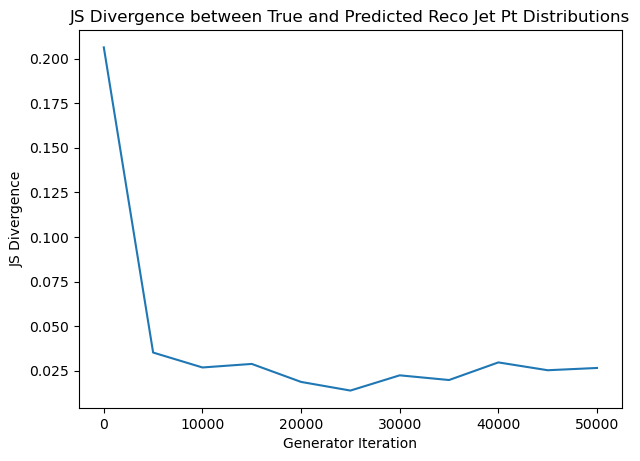

In [84]:
fig = plt.figure(figsize=(7,5), dpi=100)
ax = fig.add_subplot(111)
ax.plot(iters, js_divs)
ax.set_ylabel("JS Divergence")
ax.set_xlabel("Generator Iteration")
ax.set_title("JS Divergence between True and Predicted Reco Jet Pt Distributions")
plt.show()

## Load Weights and Make Predictions

In [163]:
cwgan.generator.load_weights(save_dir + '/training_checkpoints/gen_50000')

In [164]:
%%time
predict = np.array(cwgan.make_generator_predictions(normalized_data))

CPU times: user 47.9 s, sys: 1.95 s, total: 49.8 s
Wall time: 1.64 s


In [165]:
predict[:, 0] = predict[:, 0]*pfPtMax + pfPtMin
predict[:, 1:3] = predict[:, 1:3] * pfStd + pfMean
predict[:, 3] = predict[:, 3]*pfEMax + pfEMin

## Analyze Pt Predictions

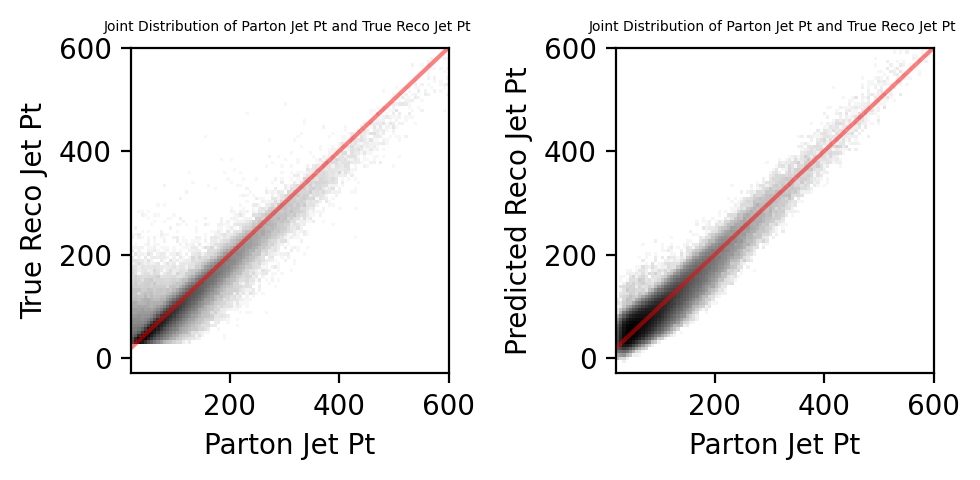

In [172]:
fig = plt.figure(figsize=(5,2.5), dpi=200)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
upper_end = 1000
x_low = 20
x_hi = 600
y_low = -30
y_hi = 600
num_bins=100


h2, xbins, ybins = np.histogram2d(data[:, 0], data[:, 4], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax1.imshow(h2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi), norm=mcolors.LogNorm(), cmap="Greys")
ax1.set_xlabel("Parton Jet Pt")
ax1.set_ylabel("True Reco Jet Pt")
ax1.set_title("Joint Distribution of Parton Jet Pt and True Reco Jet Pt ", size=5)
#ax1.set_xlim(0, 200)
#ax1.set_ylim(0, 200)


z2, xbins, ybins = np.histogram2d(data[:, 0], predict[:, 0], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
ax2.imshow(z2.T, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi), norm=mcolors.LogNorm(), cmap="Greys")
ax2.set_xlabel("Parton Jet Pt")
ax2.set_ylabel("Predicted Reco Jet Pt")
ax2.set_title("Joint Distribution of Parton Jet Pt and True Reco Jet Pt ", size=5)
#ax2.set_xlim(0, 200)
#ax2.set_ylim(-50, 200)

# plot y=x line to make comparison easier
x = np.linspace(x_low, x_hi, 10)
ax1.plot(x, x, c='r', alpha=0.5)
ax2.plot(x, x, c='r', alpha=0.5)

plt.tight_layout()
plt.show()
#plt.savefig(save_dir + '/JointPtDistributions.png')

In [173]:
joint_distributions = []
for i in range(11):
    iteration = str(i*5000)
    print(iteration)
    cwgan.generator.load_weights(save_dir + '/training_checkpoints/gen_' + iteration)
    predict = np.array(cwgan.make_generator_predictions(normalized_data))
    predict[:, 0] = predict[:, 0]*pfPtMax + pfPtMin
    predict[:, 1:3] = predict[:, 1:3] * pfStd + pfMean
    predict[:, 3] = predict[:, 3]*pfEMax + pfEMin
    z2, xbins, ybins = np.histogram2d(data[:, 0], predict[:, 0], range=[[x_low, x_hi], [y_low, y_hi]], bins=num_bins)
    joint_distributions.append(z2.T)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000


In [278]:
class JointDistribution:
    def __init__(self, true_distribution, predicted_distributions, axis_lims, iteration_interval):
        """Constructor

        Args:
            true_distribution (ndarray): Bi-dimensional histogram of the true data. 
                                         IMPORTANT: If this array came from the numpy
                                         histogram2d() function, you need to pass the 
                                         transpose to this constructor
            predicted_distributions (list): List of bi-dimensional histograms to be animated. 
            axis_lims (array_like, shape (4,)): axis limits, given as (x_min, x_max, y_min, y_max).
            figsize (array_like, shape(2,)): Size of figure
            dpi (integer): Dots per inch of figure
        """

        self.fig = plt.figure(figsize=(10, 5), dpi=200)
        self.iteration_interval = iteration_interval


        self.ax1 = self.fig.add_subplot(121)
        self.ax1.set_title("Target Joint Distribution")
        self.ax1.set_xlabel("Parton Jet Pt")
        self.ax1.set_ylabel("True Reco Jet Pt")
        self.ax1.imshow(
            true_distribution,
            origin="lower",
            aspect="auto",
            extent=axis_lims,
            norm=mcolors.LogNorm(),
            cmap="Greys",
        )
        self.ax2 = self.fig.add_subplot(122)
        self.ax2.set_title("Predicted Joint Distribution")
        self.ax2.set_xlabel("Parton Jet Pt")
        self.ax2.set_ylabel("Predicted Reco Jet Pt")
        self.title = self.ax2.set_title("")
        self.pred_image = self.ax2.imshow(
            [[]],
            origin="lower",
            aspect="auto",
            extent=axis_lims,
            norm=mcolors.LogNorm(),
            cmap="Greys",
        )
        self.predicted_distributions = predicted_distributions
        self.num_frames = len(predicted_distributions)


    def init(self):
        x = np.linspace(20, 600, 10)
        self.ax2.plot(x, x, c='r', alpha=0.5)
        self.ax1.plot(x, x, c='r', alpha=0.5)
        return self.pred_image

    def update(self, frame):
        self.pred_image.set_data(self.predicted_distributions[frame])
        self.title.set_text("Predicted Joint Distribution Iteration: {}".format(frame*self.iteration_interval))
        return self.pred_image, self.title

    def make_animation(self):
        anim = animation.FuncAnimation(
            self.fig,
            self.update,
            init_func=self.init,
            frames=np.arange(self.num_frames),
            interval=500
        )
        return anim

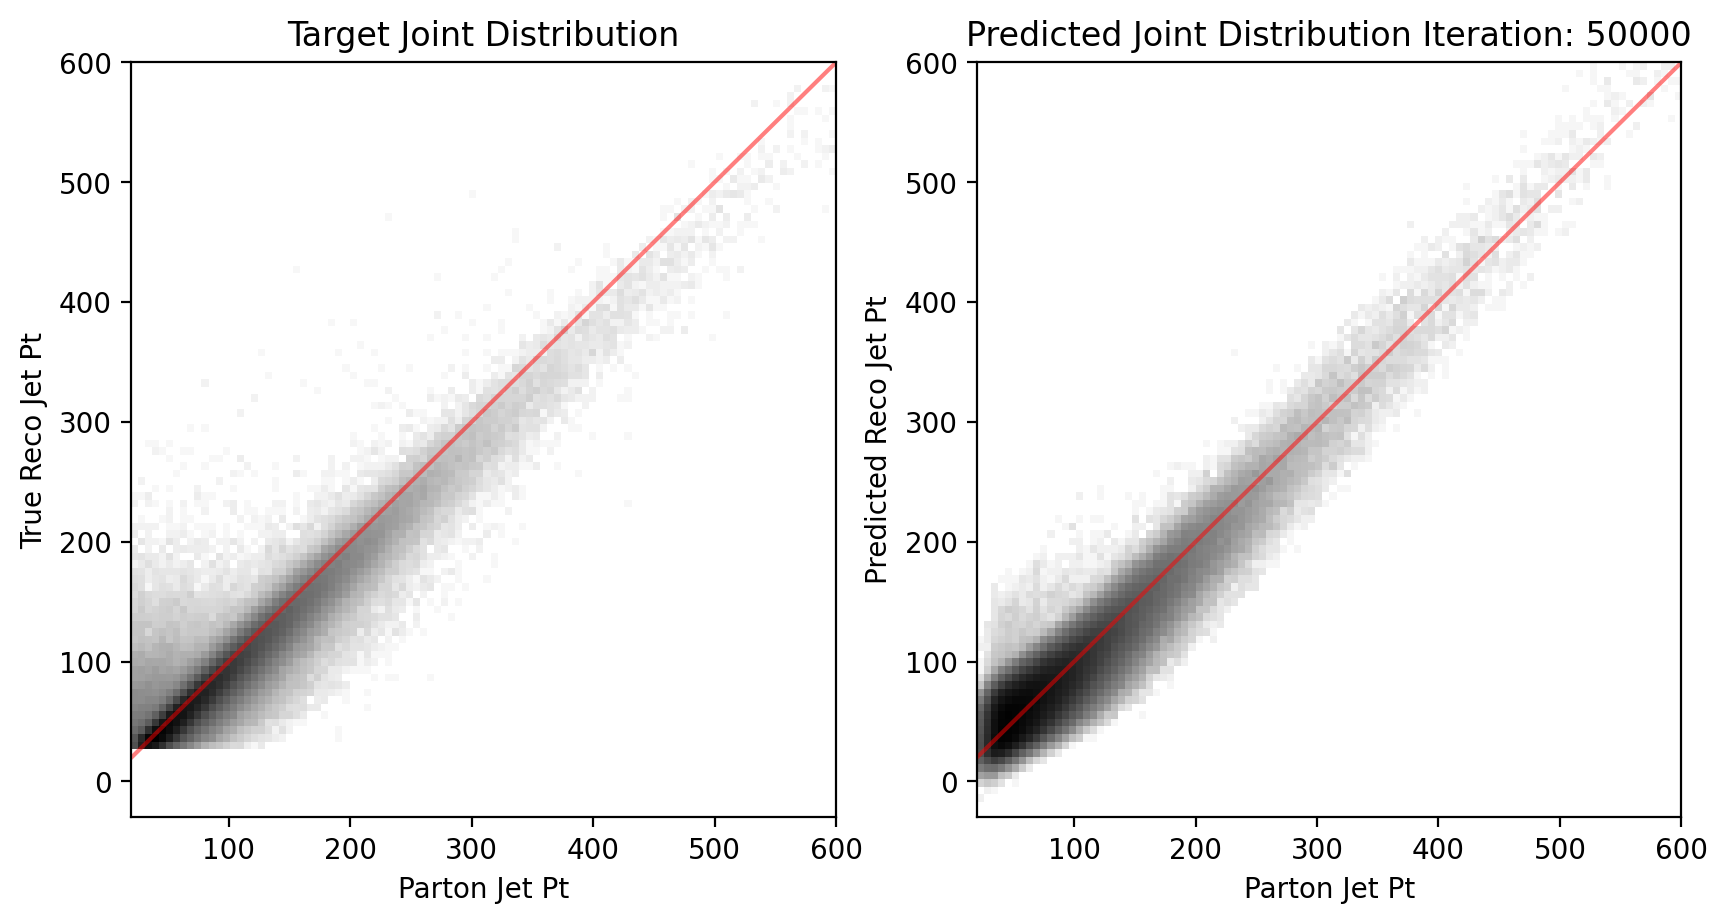

In [279]:
#from Animations import JointDistribution
jd = JointDistribution(h2.T, joint_distributions, (20, 600, -30, 600), 5000)
anim = jd.make_animation()
HTML(anim.to_jshtml())


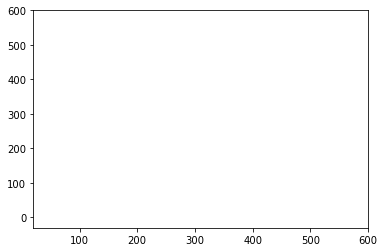

In [180]:
x_low = 20
x_hi = 600
y_low = -30
y_hi = 600
num_bins=100
fig, ax = plt.subplots()
distribution = [[]]
image = plt.imshow(distribution, origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi), norm=mcolors.LogNorm(), cmap="Greys")
def init():
    return image

In [182]:
def update(frame):
    image.set_data(joint_distributions[frame])
    return image

In [185]:
from matplotlib import animation, rc
from IPython.display import HTML
anim = animation.FuncAnimation(fig, update, init_func=init, frames=np.arange(11))

In [187]:
HTML(anim.to_jshtml())

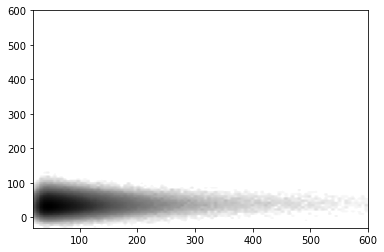

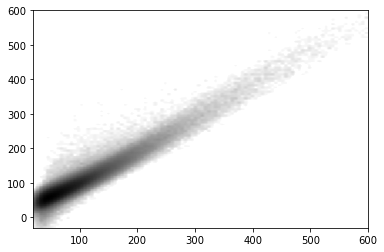

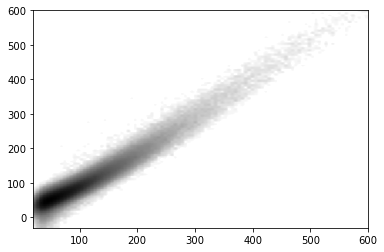

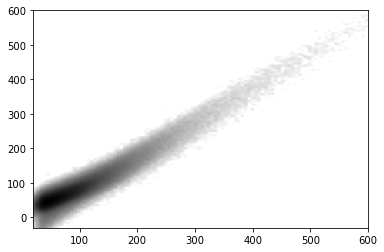

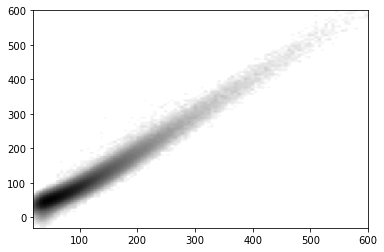

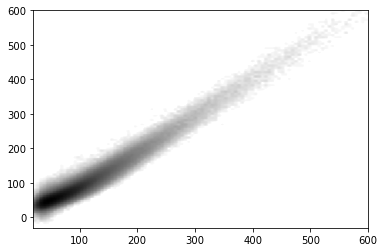

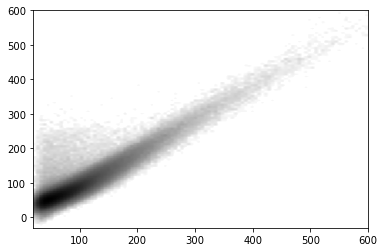

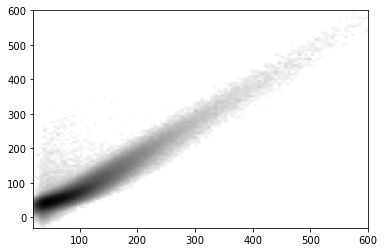

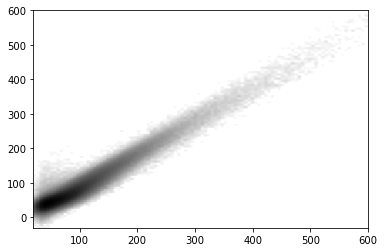

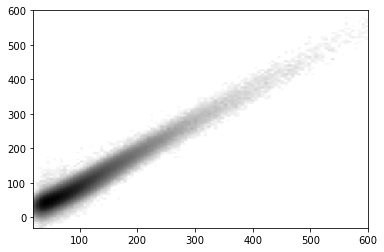

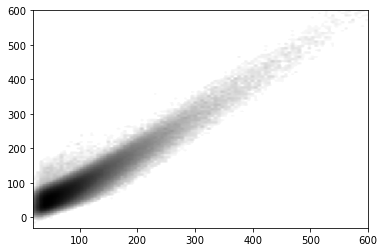

In [174]:

for i in range(11):
    plt.imshow(joint_distributions[i], origin='lower', aspect='auto', extent=(x_low, x_hi, y_low, y_hi), norm=mcolors.LogNorm(), cmap="Greys")
    plt.show()

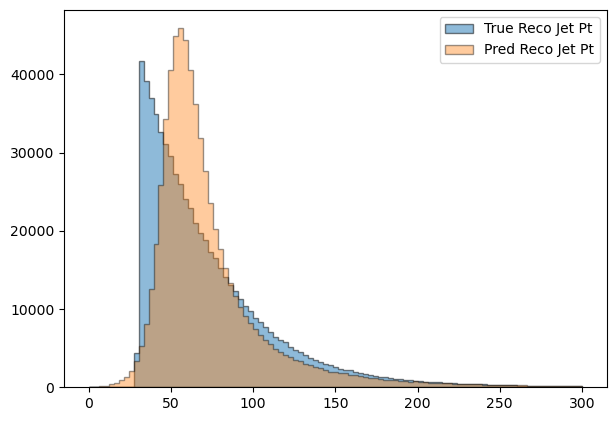

In [135]:
fig = plt.figure(figsize=(7,5), dpi=100)
bins = np.linspace(0, 300, 100)
ax = fig.add_subplot(111)
ax.hist(data[:, 4], label="True Reco Jet Pt", bins=bins, alpha=0.5, ec="k", histtype='stepfilled')
ax.hist(predict[:, 0], label="Pred Reco Jet Pt", bins=bins, alpha=0.4, ec="k", histtype='stepfilled')
ax.legend()
plt.show()

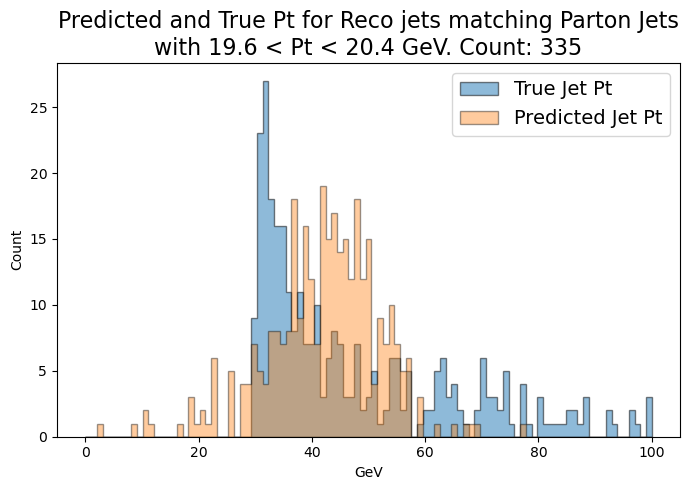

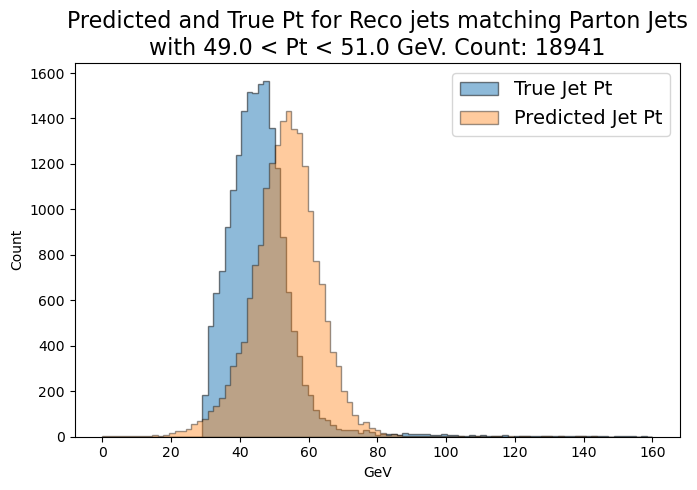

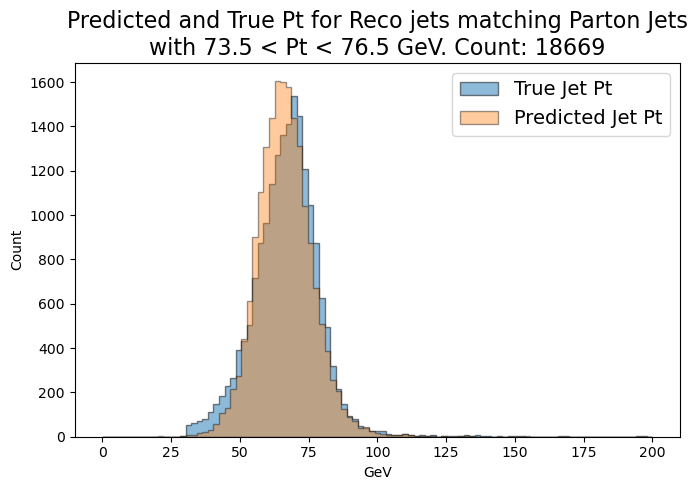

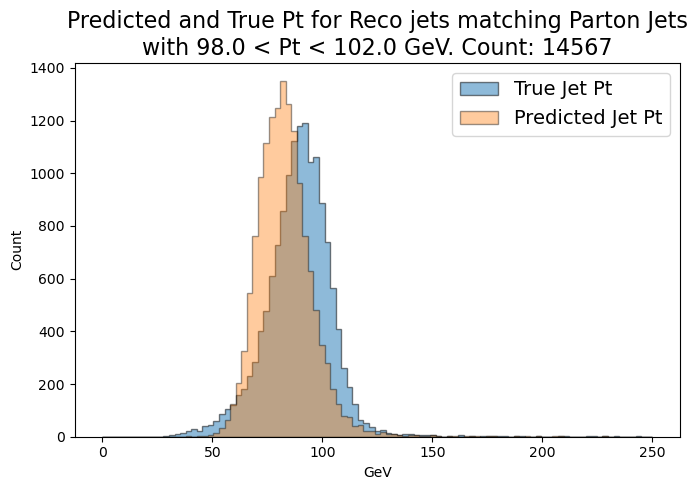

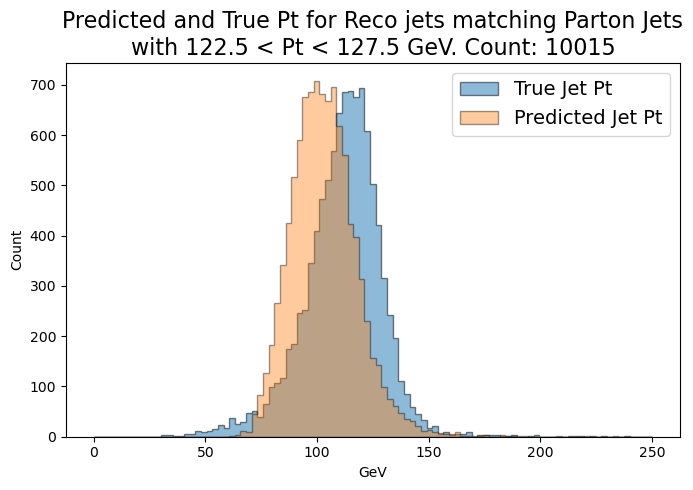

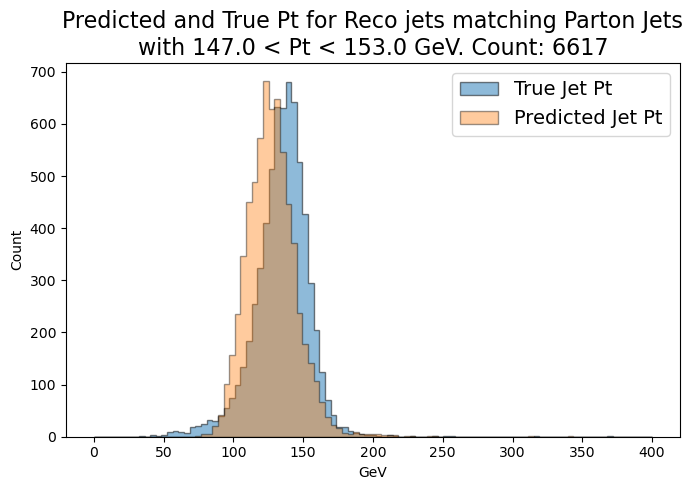

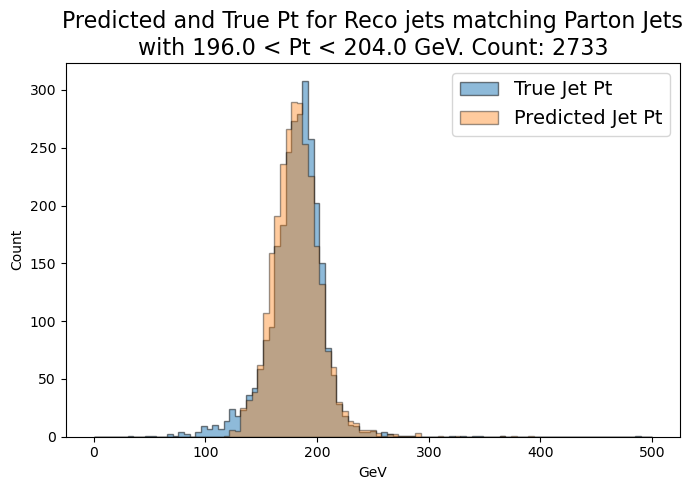

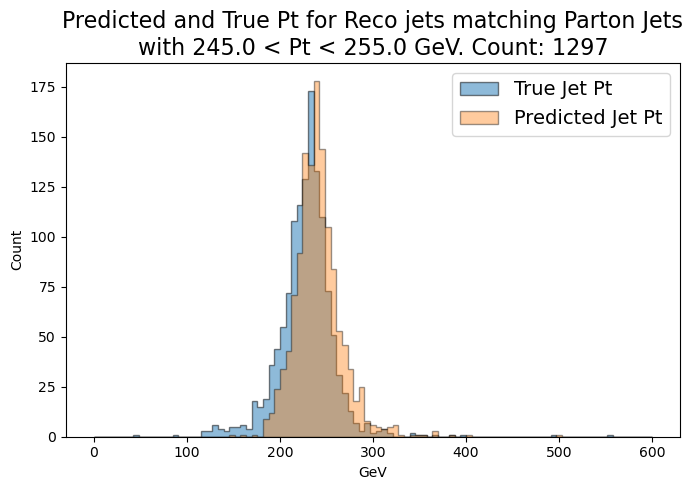

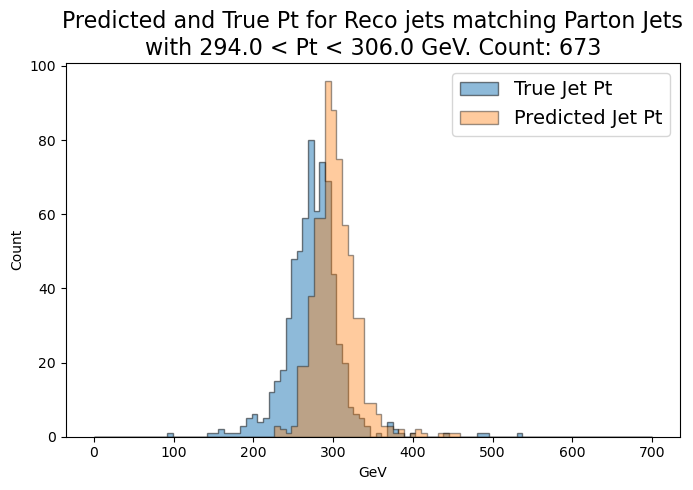

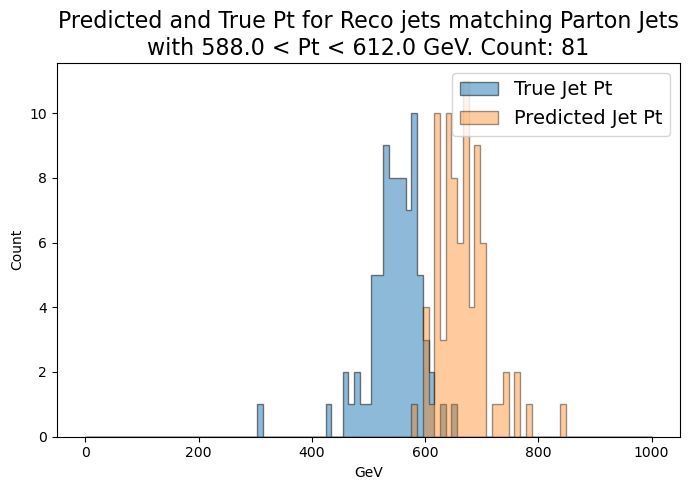

In [136]:
range_highs = [100, 160, 200, 250, 250, 400, 500, 600, 700, 1000]
range_lows = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
j = 0
for center in [20, 50, 75, 100, 125, 150, 200, 250, 300, 600]:        
    recoPt = []
    predPt = []
    low = center - center/50
    high = center + center/50
    for i in range(len(data)):
        if (data[i, 0] > low and data[i, 0] < high):
            recoPt.append(data[i, 4])
            predPt.append(predict[i, 0])
    bins = np.linspace(range_lows[j], range_highs[j], 100)
    fig = plt.figure(figsize=(7,5), dpi=100)
    ax = fig.add_subplot(111)
    ax.hist(recoPt, bins=bins, label='True Jet Pt', alpha=0.5, ec="k", histtype='stepfilled')
    ax.hist(predPt, bins=bins, label='Predicted Jet Pt', alpha=0.4, ec="k", histtype='stepfilled')
    #ax.hist(energy, bins=bins, label='E', alpha=0.5)
    ax.set_xlabel("GeV")
    ax.set_ylabel("Count")
    ax.set_title("\n".join(wrap("Predicted and True Pt for Reco jets matching Parton Jets with {} < Pt < {} GeV. Count: {}".format(low, high, len(recoPt)), width=60)), fontsize=16)
    #ax.axvline(x=center/2)

    ax.legend(fontsize=14)
    plt.tight_layout()
    #ax.set_yscale('log')
    plt.show()
    #fig.savefig(save_dir+"/PtDistLog{}.png".format(j), facecolor="white", transparent="True")
    j+=1
